## Confirm Py6S installation

In [1]:
from Py6S import *
SixS.test()


6S wrapper script by Robin Wilson
Using 6S located at /usr/local/bin/sixsV1.1
Running 6S using a set of test parameters
6sV version: 1.1
The results are:
Expected result: 619.158000
Actual result: 619.158000
#### Results agree, Py6S is working correctly


0

Running for many wavelengths - this may take a long time


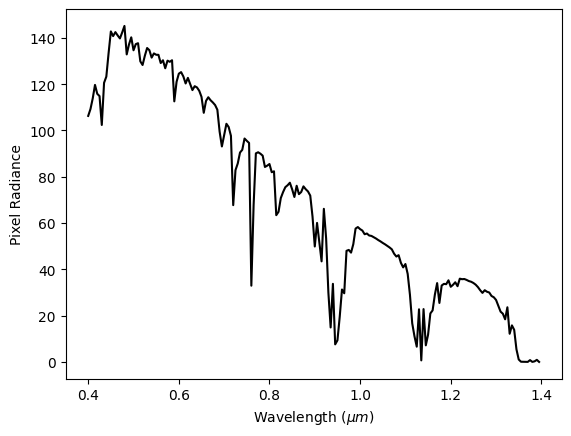

In [3]:
# Create a SixS object called s (used as the standard name by convention)
s = SixS()
# Run the 6S simulation defined by this SixS object across the
# whole VNIR range
wavelengths, results = SixSHelpers.Wavelengths.run_vnir(s, output_name="pixel_radiance")
# Plot these results, with the y axis label set to "Pixel Radiance"
SixSHelpers.Wavelengths.plot_wavelengths(wavelengths, results, "Pixel Radiance")

## Calculate maximum solar energy

In [142]:
import random
import logging
import pytz
import pvlib
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta, timezone
from timezonefinder import TimezoneFinder

In [3]:
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(levelname)s - %(message)s')

#### Calculate DNI (direct normal irradiance)

In [189]:
def get_solar_irradiance(latitude, longitude, altitude, dthz):
    s = SixS()
    datetime_str = dthz.strftime('%Y-%m-%dT%H:%M:%S')
    s.atmos_profile = AtmosProfile.FromLatitudeAndDate(latitude, datetime_str)
    s.altitudes.set_target_custom_altitude(altitude / 1000)
    
    s.geometry = Geometry.User()
    s.geometry.from_time_and_location(latitude, longitude, datetime_str, 0, 0)
    
    if s.geometry.solar_z > 90:
        logging.info(f"Sun is below the horizon at {dthz}")
        return (0, 0, 0, 0)
    
    s.run()
    
    ghi = s.outputs.direct_solar_irradiance + s.outputs.environmental_irradiance
    dni = ghi / math.cos(math.radians(s.outputs.solar_z))
    
    print(dni, ghi, s.outputs.direct_solar_irradiance, s.outputs.environmental_irradiance)

    return (dni, ghi, s.outputs.direct_solar_irradiance, s.outputs.environmental_irradiance)


In [191]:
lat = 42
lon = -70
alt = 0
dtz = datetime(2023, 6, 15, tzinfo=pytz.utc)
rad_by_hour = []

for hour in range(0, 24):
    dthz = dtz + timedelta(hours=hour)
    irradiance = get_solar_irradiance(lat, lon, alt, dthz)
    print(irradiance)
    rad_by_hour.append({'Hour': hour,
                        'dni': irradiance[0],
                        'ghi': irradiance[1],
                        'diffuse_horizontal': irradiance[3],
                        'direct_horizontal': irradiance[2]})
                        

df = pd.DataFrame(rad_by_hour)
df.set_index('Hour', inplace=True)
df['ghi'] = df['direct_horizontal'] + df['diffuse_horizontal']
print(df['dni'].mean())
df.to_csv('/Users/timothydonohue/Downloads/solar_irradiance_ts.csv')
df

2024-03-11 16:31:54,949 - INFO - Sun is below the horizon at 2023-06-15 01:00:00+00:00
2024-03-11 16:31:54,951 - INFO - Sun is below the horizon at 2023-06-15 02:00:00+00:00
2024-03-11 16:31:54,953 - INFO - Sun is below the horizon at 2023-06-15 03:00:00+00:00
2024-03-11 16:31:54,955 - INFO - Sun is below the horizon at 2023-06-15 04:00:00+00:00
2024-03-11 16:31:54,957 - INFO - Sun is below the horizon at 2023-06-15 05:00:00+00:00
2024-03-11 16:31:54,959 - INFO - Sun is below the horizon at 2023-06-15 06:00:00+00:00
2024-03-11 16:31:54,961 - INFO - Sun is below the horizon at 2023-06-15 07:00:00+00:00
2024-03-11 16:31:54,963 - INFO - Sun is below the horizon at 2023-06-15 08:00:00+00:00
2024-03-11 16:31:54,965 - INFO - Sun is below the horizon at 2023-06-15 09:00:00+00:00


23.482899486826444 1.229 0.0 1.229
(23.482899486826444, 1.229, 0.0, 1.229)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
(0, 0, 0, 0)
66.87784560332943 10.462 2.823 7.639
(66.87784560332943, 10.462, 2.823, 7.639)
303.5032715799698 98.811 75.313 23.498
(303.5032715799698, 98.811, 75.313, 23.498)
561.3359999999999 280.668 238.154 42.514
(561.3359999999999, 280.668, 238.154, 42.514)
754.3726679008347 494.913 434.06 60.853
(754.3726679008347, 494.913, 434.06, 60.853)
881.2887347303786 694.465 618.096 76.369
(881.2887347303786, 694.465, 618.096, 76.369)
960.8452493233642 848.376 760.641 87.735
(960.8452493233642, 848.376, 760.641, 87.735)
997.3069696090707 937.162 843.043 94.119
(997.3069696090707, 937.162, 843.043, 94.119)
1005.4736358800806 950.694 855.612 95.082
(1005.4736358800806, 950.694, 855.612, 95.082)
971.4798454476099 887.491 796.93 90.561
(971.4798454476099, 887.491, 796.93, 90.561)
910.245838043605 754.6279999999999 673.

,dni,ghi,diffuse_horizontal,direct_horizontal
Hour,,,,
0,23.482899,1.229,1.229,0.000
1,0.000000,0.000,0.000,0.000
2,0.000000,0.000,0.000,0.000
3,0.000000,0.000,0.000,0.000
4,0.000000,0.000,0.000,0.000
5,0.000000,0.000,0.000,0.000
6,0.000000,0.000,0.000,0.000
7,0.000000,0.000,0.000,0.000
8,0.000000,0.000,0.000,0.000


In [ ]:
import pysolar.solar as solar

latitude = 42  
longitude = -70  
altitude = 0  

# Replace with your actual datetime, making sure it's timezone-aware
dthz = datetime(2023, 6, 15, 12, tzinfo=pytz.utc)

solar_altitude = solar.get_altitude(latitude, longitude, dthz)
solar_azimuth = solar.get_azimuth(latitude, longitude, dthz)
solar_radiation = solar.radiation.get_radiation_direct(dthz, solar_altitude)

print(f"Solar Altitude: {solar_altitude}")
print(f"Solar Azimuth: {solar_azimuth}")
print(f"Solar Radiation: {solar_radiation}")

In [6]:
time_step = 1
speed = 13 # m/s

# Constants
earth_circumference_km = 40075
degrees_per_latitude = earth_circumference_km / 360
travel_distance_km = speed * time_step * 3600 / 1000  # Speed * time * conversion to km

# Latitude steps
degrees_per_step_lat = travel_distance_km / degrees_per_latitude
global_lat_steps = int(360 / degrees_per_step_lat)

# Longitude steps at a representative latitude (e.g., 45 degrees)
representative_lat = 45
degrees_per_longitude_at_lat = np.cos(np.radians(representative_lat)) * degrees_per_latitude
degrees_per_step_lon = travel_distance_km / degrees_per_longitude_at_lat
num_lon_steps = int(360 / degrees_per_step_lon)

global_lat_steps, num_lon_steps

(856, 605)

In [11]:
# Constants for one hemisphere and hour of the year
num_lat_steps = int(global_lat_steps / 2)  # global steps divided by 2 for one hemisphere
num_time_steps = int(24 / time_step * 365 / 2)  # Assuming 1 time step per hour for half a year
num_actions = 9  # Actions remain the same

In [12]:
def take_action(state, action):
    lat_index, lon_index, time_index = state
    
    # Defining how each action changes the latitude and longitude index
    action_effects = {
        0: (1, 0),  # 'N'
        1: (1, 1),  # 'NE'
        2: (0, 1),  # 'E'
        3: (-1, 1), # 'SE'
        4: (-1, 0), # 'S'
        5: (-1, -1),# 'SW'
        6: (0, -1), # 'W'
        7: (1, -1), # 'NW'
        8: (0, 0),  # 'STAY'
    }
    
    lat_change, lon_change = action_effects[action]
    
    # Calculate new latitude index, ensuring it's within bounds
    new_lat_index = max(0, min(num_lat_steps - 1, lat_index + lat_change))
    
    # Calculate new longitude index, ensuring it's within bounds
    # This simple wrap-around logic may need adjustment based on your specific requirements
    new_lon_index = (lon_index + lon_change) % num_lon_steps
    
    # Update the time index (assumes 1 step per time increment, adjust if using larger time steps)
    new_time_index = (time_index + 1) % num_time_steps

    return new_lat_index, new_lon_index, new_time_index


In [47]:
def convert_state_to_sensible_values(state):
    lat_index, lon_index, time_index = state

    # Convert latitude index to actual latitude
    geo_lat = (lat_index / num_lat_steps) * 90  # For Northern Hemisphere

    # Convert longitude index to actual longitude
    geo_lon = (lon_index / num_lon_steps) * 360 - 180  # Longitude range -180 to 180

    # Convert time index to actual hour of the year
    hours = time_index * time_step  # Adjust based on your time step duration

    # Calculate UTC datetime from the hour of the year
    dthz = datetime(2023, 1, 1, tzinfo=pytz.utc) + timedelta(hours=hours) - timedelta(days=1)
    if logging.getLogger().getEffectiveLevel() == logging.DEBUG:
        tf = TimezoneFinder()
        time_zone_str = tf.timezone_at(lat=geo_lat, lng=geo_lon)
        
        if time_zone_str:
            time_zone = pytz.timezone(time_zone_str)
            dthl = dthz.astimezone(time_zone)
    else:
        # Calculate local time adjustment based on longitude
        # Each 15 degrees of longitude corresponds to one hour
        local_time_offset = timedelta(hours=geo_lon / 15)
        dthl = dthz + local_time_offset

    return geo_lat, geo_lon, dthz, dthl


def take_action_and_get_reward(state, action):
    new_state = take_action(state, action)
    # Convert state indices to actual latitude, longitude, and time for irradiance calculation
    # Assuming you have functions or a method to convert indices to actual values
    geo_lat, geo_lon, dthz, dthl = convert_state_to_sensible_values(new_state)
    reward = get_solar_irradiance(geo_lat, geo_lon, actual_altitude, dthz)[0]
    logging.info(f"Vehicle moved to {geo_lat}, {geo_lon} at {dthz} ({dthl}, {new_state}) with "
                f"reward {reward} w/m^2")
    #print(new_state, reward)
    return new_state, reward

In [ ]:
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.95
EPISODES = 2

actual_altitude = 5400

epsilon = 1.0  # Initial epsilon
epsilon_min = 0.01  # Minimum epsilon value
epsilon_decay = 0.995  # Decay factor

q_table = np.zeros((num_lat_steps, num_lon_steps, num_time_steps, num_actions))
logging.info(f"Q-table created with shape: {q_table.shape}")

initial_time_index = 1896
initial_lat_index = int(num_lat_steps / 2)
initial_lon_index = int(num_lon_steps / 2)

for episode in range(EPISODES):
    state = (initial_lat_index, initial_lon_index, initial_time_index)
    init_geo_lat, init_geo_lon, init_dtmz, init_dthl = convert_state_to_sensible_values(state)
    
    if (episode) % 10 == 0 or episode == 0:
        logging.info(f"Episode {episode} - Epsilon: {epsilon}")
    logging.debug(f"Ep. {episode} initialized at {init_dtmz} ({init_dthl}), {init_geo_lat}, {init_geo_lon} "
                 f"(index state: {state}); epsilon: {epsilon}")
    
    for step in range(12):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, num_actions - 1)  # Explore
            logging.debug(f"Epsilon-greedy explores with action {action} at step {step} (ep. {episode})")
        else:
            action = np.argmax(q_table[state])  # Exploit
            logging.debug(f"Epsilon-greedy exploits with action {action} at step {step} (ep. {episode})")
        
        # Execute the action
        new_state, reward = take_action_and_get_reward(state, action)
        
        # Update the Q-value
        best_future_q = np.max(q_table[new_state])
        # Ensure that 'state' is a tuple and 'action' is an integer
        q_table[state + (action,)] = q_table[state + (action,)] + \
                                     LEARNING_RATE * (reward + DISCOUNT_FACTOR * best_future_q - q_table[state + (action,)])

        # Transition to the new state
        state = new_state
    
    # Decay epsilon
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
